In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import os
import cv2
from PIL import Image
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


# DENOISING DOCUMENTS

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


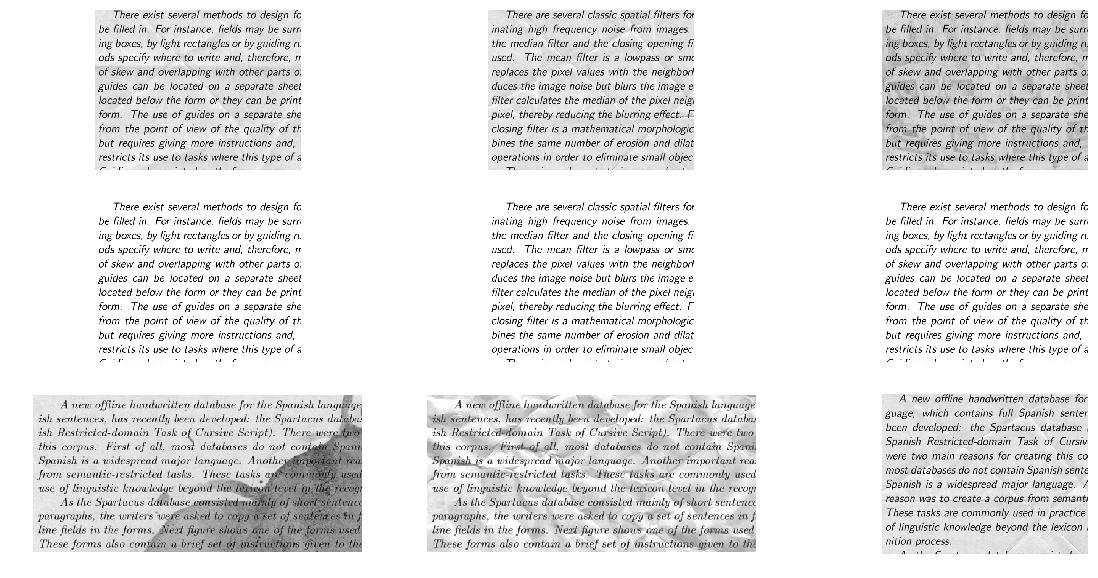

In [2]:
import glob
train_images = glob.glob('./data/train/*.png')
train_noisy = glob.glob('./data/train_cleaned/*.png')
test_images = glob.glob('./data/test/*.png')

print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_noisy))
print("Total number of samples in the test set: ", len(test_images))

# Lets' plot a few samples
# First row will be raw data, second row will be the corresponding cleaned images
samples = train_images[:3] + train_noisy[:3] + test_images[:3]

f, ax = plt.subplots(3, 3, figsize=(20,10))
for i, img in enumerate(samples):
#     img = imread(img)
    img = cv2.imread(img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()    

In [3]:
X_train = []
X_train_noisy = []
X_test = []

# Convert each image to grayscale and reshape to 420x540.
for img in train_images:
    img = load_img(img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X_train.append(img)

for img in train_noisy:
    img = load_img(img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X_train_noisy.append(img)
    
for img in test_images:
    img = load_img(img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X_test.append(img)

X_train = np.array(X_train)
X_train_noisy = np.array(X_train_noisy)
X_test = np.array(X_test)

x_train_noisy, y_test_noisy, x_train, y_test = train_test_split(X_train_noisy, X_train, test_size=0.1, random_state=111)

print("Size of x_train : ", x_train.shape)
print("Size of x_train_noisy : ", x_train_noisy.shape)
print("Size of x_test_noisy : ", y_test_noisy.shape)
print("Size of x_test : ", y_test.shape)

Size of x_train :  (129, 420, 540, 1)
Size of x_train_noisy :  (129, 420, 540, 1)
Size of x_test_noisy :  (15, 420, 540, 1)
Size of x_test :  (15, 420, 540, 1)


## FIRST MODEL

In [4]:
input_img = Input(shape=(420, 540, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 420, 540, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 420, 540, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 210, 270, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 210, 270, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 105, 135, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 105, 135, 32)      9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 210, 270, 32)      0         
__________

In [25]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                batch_size=8,
                shuffle=True,
                validation_data=(y_test_noisy, y_test))

Train on 129 samples, validate on 15 samples
Epoch 1/30
129/129 [==============================] - 2s - loss: 0.5977 - val_loss: 0.5375
Epoch 2/30
129/129 [==============================] - 1s - loss: 0.5377 - val_loss: 0.5529ss:
Epoch 3/30
129/129 [==============================] - 1s - loss: 0.5300 - val_loss: 0.5687
Epoch 4/30
129/129 [==============================] - 1s - loss: 0.5242 - val_loss: 0.5056
Epoch 5/30
129/129 [==============================] - 1s - loss: 0.5107 - val_loss: 0.5094
Epoch 6/30
129/129 [==============================] - 1s - loss: 0.5092 - val_loss: 0.5012
Epoch 7/30
129/129 [==============================] - 1s - loss: 0.5061 - val_loss: 0.5062
Epoch 8/30
129/129 [==============================] - 1s - loss: 0.5036 - val_loss: 0.4973
Epoch 9/30
129/129 [==============================] - 1s - loss: 0.5021 - val_loss: 0.4969
Epoch 10/30
129/129 [==============================] - 1s - loss: 0.4977 - val_loss: 0.4947
Epoch 11/30
129/129 [====================

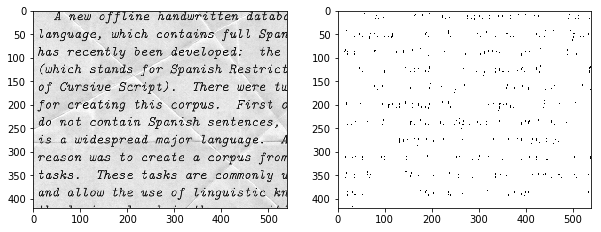

In [37]:
sample_test = load_img(test_images[10], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

## BETTER MODEL

In [17]:
input_img = Input(shape=(420,540,1), name='image_input')

#enoder 
x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

#decoder
x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
x = UpSampling2D((2,2), name='upsample1')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
x = UpSampling2D((2,2), name='upsample2')(x)
x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

    
#model
autoencoder = Model(inputs=input_img, outputs=x)
autoencoder.summary()
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 210, 270, 64)      0         
__________

In [21]:
from keras.callbacks import TensorBoard

autoencoder.fit(X_train_noisy, X_train,
                epochs=30,
                batch_size=8,
                shuffle=True,
                validation_split=0.2)

Train on 115 samples, validate on 29 samples
Epoch 1/30
115/115 [==============================] - 1s - loss: 0.4715 - val_loss: 0.4770
Epoch 2/30
115/115 [==============================] - 1s - loss: 0.4700 - val_loss: 0.4658
Epoch 3/30
115/115 [==============================] - 1s - loss: 0.4702 - val_loss: 0.4658
Epoch 4/30
115/115 [==============================] - 1s - loss: 0.4674 - val_loss: 0.4699
Epoch 5/30
115/115 [==============================] - 1s - loss: 0.4661 - val_loss: 0.4619
Epoch 6/30
115/115 [==============================] - 1s - loss: 0.4669 - val_loss: 0.4631
Epoch 7/30
115/115 [==============================] - 1s - loss: 0.4646 - val_loss: 0.4691
Epoch 8/30
115/115 [==============================] - 1s - loss: 0.4639 - val_loss: 0.4663
Epoch 9/30
115/115 [==============================] - 1s - loss: 0.4630 - val_loss: 0.4712
Epoch 10/30
115/115 [==============================] - 1s - loss: 0.4628 - val_loss: 0.4598
Epoch 11/30
115/115 [=======================

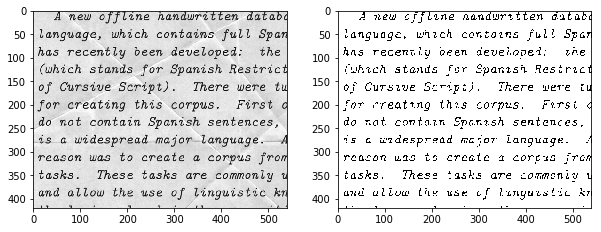

In [22]:
sample_test = load_img(test_images[10], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()